# Installing / importing required utilities

In [ ]:
# utilities installation
!pip install datasets
!pip install conllu
!pip install torch


In [2]:
# import libraries
from functools import partial
from datasets import load_dataset
import torch
import torch.nn as nn
import numpy as np
import os
from collections import Counter
from conllu import parse_incr
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Useful statistics

The Universal Dependencies Treebank contains a large number of annotated sentences that can be analyzed for linguistic properties. We will examine the dependency relationships between sentences in our analysis. Let's first provide some useful statistics regarding this dataset before continuing with the task.

In [ ]:
# load the dataset to be used for calculating the statistics

full_dataloader = load_dataset('universal_dependencies', 'en_lines', split='train')

Plot indicates that most sentences have a length of nine to fifteen tokens. Eleven tokens make up the most commonly occurring sentence.

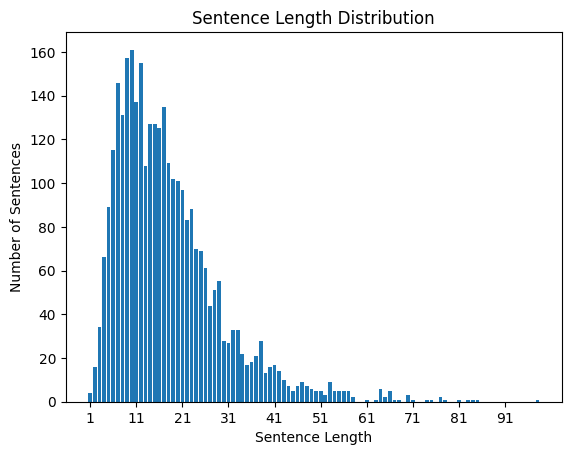

In [ ]:
sentence_lengths = Counter()

for sentence in full_dataloader:
    tokens = sentence['tokens']
    length_each_sen = len(tokens)
    sentence_lengths[length_each_sen] += 1

# Extract the lengths and counts for plotting
lengths = list(sentence_lengths.keys())
counts = list(sentence_lengths.values())

# Rescale the graph with step size of 10
x_ticks = np.arange(min(lengths), max(lengths)+1, 10)

# Plot the bar graph
plt.bar(lengths, counts)
plt.xticks(x_ticks)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.title('Sentence Length Distribution')
plt.show()

We can determine which dependency relations are most prevalent in the data by tallying the occurrences of each relation and computing their frequencies. By doing this, we can learn more about the most prevalent grammatical constructions. Most commonly encountered dependency relations are “Punctuation”, “Case Marker”, “Determiner”, and “Nominal Subject”.

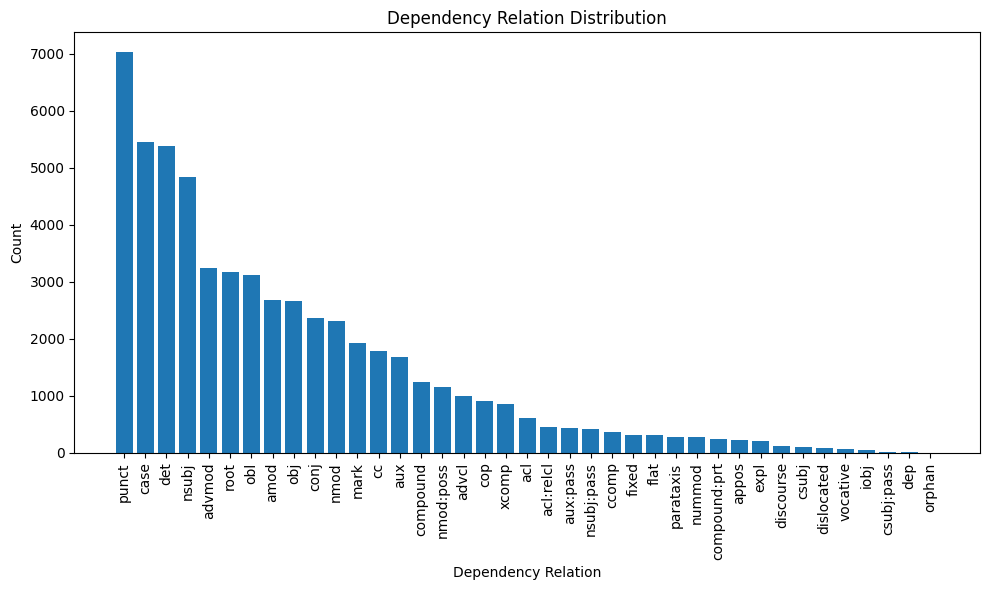

In [ ]:
# Compute the distribution of dependency relations
dep_rel_counts = Counter()

for sentence in full_dataloader:
    dep_rels = sentence['deprel']
    dep_rel_counts.update(dep_rels)

# Sort the dependency relations and their counts in descending order
sorted_dep_rels, sorted_counts = zip(*sorted(dep_rel_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(sorted_dep_rels, sorted_counts)
plt.xlabel('Dependency Relation')
plt.ylabel('Count')
plt.title('Dependency Relation Distribution')
plt.xticks(rotation=90)
plt.tight_layout()  # Improve spacing between bars and labels


plt.show()

The three most prevalent tags, according to the plot displaying the distribution of Part-of-Speech (POS) tags, are "Noun", "Punctuation" and "Verb". A high noun frequency, for example, may indicate descriptive writing.

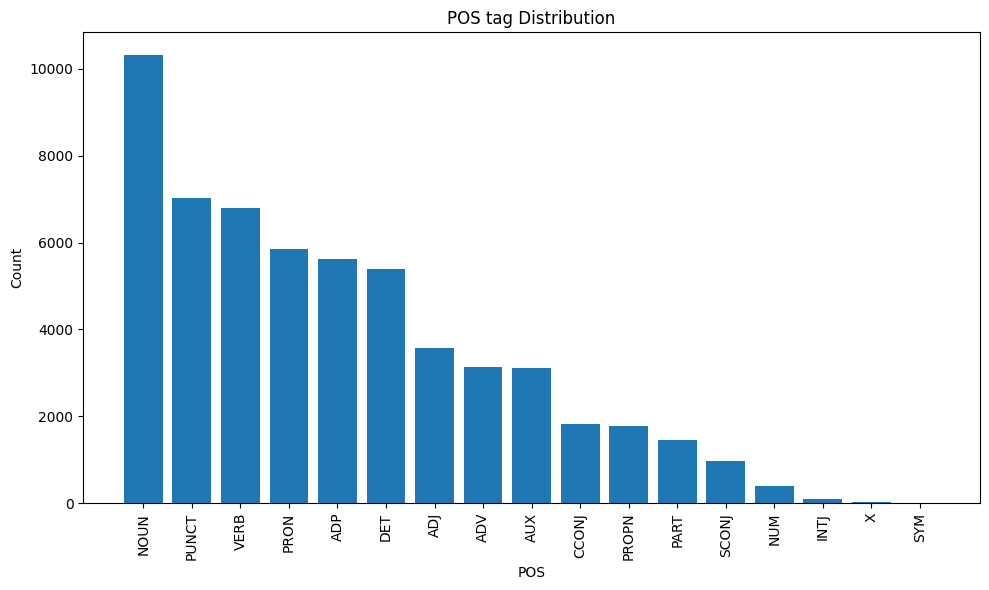

In [ ]:
# Define a dictionary to map POS tag numbers to names
pos_tag_names = {
    '0': 'NOUN',
    '1': 'PUNCT',
    '2': 'ADP',
    '3': 'NUM',
    '4': 'SYM',
    '5': 'SCONJ',
    '6': 'ADJ',
    '7': 'PART',
    '8': 'DET',
    '9': 'CCONJ',
    '10': 'PROPN',
    '11': 'PRON',
    '12': 'X',
    '13': '_',
    '14': 'ADV',
    '15': 'INTJ',
    '16': 'VERB',
    '17': 'AUX'
}

# Compute the distribution of dependency relations
pos_tag_counts = Counter()

for sentence in full_dataloader:
    pos_tag = [str(tag) for tag in sentence['upos']]
    pos_tag_counts.update(pos_tag)

# Sort the dependency relations and their counts in descending order
sorted_pos_tag, sorted_counts = zip(*sorted(pos_tag_counts.items(), key=lambda x: x[1], reverse=True))

# Map numbers to names for plotting
sorted_pos_tag_names = [pos_tag_names[tag] for tag in sorted_pos_tag]

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(sorted_pos_tag_names, sorted_counts)
plt.xlabel('POS')
plt.ylabel('Count')
plt.title('POS tag Distribution')
plt.xticks(rotation=90)
plt.tight_layout()  # Improve spacing between bars and labels
plt.show()


# Arc-Eager / Oracle implementation and testing the functionalities


In [3]:
class ArcEager:
    def __init__(self, sentence):

        # sentence is the input for which we want to build our Arc-Eager parser
        # it is a list of words


        self.sentence = sentence
        # initialize the buffer with the indexes of the words in the sentence
        self.buffer = [i for i in range(len(self.sentence))]
        # initialize the stack empty
        self.stack = []
        # representation of the tree
        # every word will have a -1 assigned -> no father has been assigned yet
        self.arcs = [-1 for _ in range(len(self.sentence))]
        # means that in the stack now is the ROOT
        self.shift()



    def shift(self):
      """
      Performs the shift operation, moving a word from the buffer to the stack.
      """
      if len(self.buffer) > 0:
       b1 = self.buffer[0]
       self.buffer = self.buffer[1:]
       self.stack.append(b1)

    def left_arc(self):
      """
      Performs the left arc operation,
      adding an arc from the second item in the stack to the first item in the stack
      """
      s1 = self.stack.pop()
      b1 = self.buffer[0]
      self.arcs[s1] = b1


    def right_arc(self):

       b1 = self.buffer[0]
       s1 = self.stack[-1]
       self.arcs[b1] = s1
       self.stack.append(b1)
       self.buffer = self.buffer[1:]

    def reduce(self):
     """
      Performs the reduce operation, removing the first item from the stack
     """
     self.stack.pop()


    def is_tree_final(self):
      """
      Checks if the tree is final, i.e. if the buffer is empty and the stack contains only one item
      """
      return len(self.stack) == 1 and len(self.buffer) == 0


    def print_configuration(self):
      """
      Prints the current configuration of the parser
      """

      s = [self.sentence[i] for i in self.stack]
      b = [self.sentence[i] for i in self.buffer]
      print(s,b)
      print(self.arcs)



In [4]:
class Oracle:
  """
  Oracle class that implements the oracle for the arc-eager transition system

  Args:
    parser (ArcEager): the parser
    gold_tree (list): the gold tree

  """
  def __init__(self, parser, gold_tree):

    self.parser = parser
    self.gold = gold_tree

  def has_head(self, stack_top):
    return  self.parser.arcs[stack_top] != -1

  def has_all_children(self, stack_top):
    i = 0
    for arc in self.gold:
      if arc == stack_top:
        if self.parser.arcs[i] != stack_top:
          return False
      i+=1
    return True

  def GoldAction(self):

     if len(self.parser.buffer) > 0 and self.parser.stack[-1] != '<ROOT>' and self.gold[self.parser.stack[-1]] == self.parser.buffer[0]:
       return 'LEFT-ARC'
     elif  len (self.parser.buffer) > 0  and self.gold[self.parser.buffer[0]] == self.parser.stack[-1]:
       return 'RIGHT-ARC'
     elif self.has_all_children(self.parser.stack[-1]) and self.has_head(self.parser.stack[-1]) and len(self.parser.stack) >= 2:
       return 'REDUCE'
     else:
       return 'SHIFT'

In [ ]:
sentence = [ '<ROOT>',"this", "mode", "conform", "closely", "to", "the", "ANSI-92", "level", "1", "specification", ",", "but", "be", "not", "ANSI-92", "level", "1", "compliant", "." ]
gold = [-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

while not parser.is_tree_final():
    if oracle.GoldAction() == "RIGHT-ARC":
        parser.right_arc()
    elif oracle.GoldAction() == "LEFT-ARC" :
        parser.left_arc()
    elif oracle.GoldAction() == "REDUCE":
        parser.reduce()
    elif oracle.GoldAction() == "SHIFT":
        parser.shift()


print(parser.arcs)
print(gold)

[-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3]
[-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3]


# Useful functions for preprocessing steps

In [5]:
def is_projective(tree):
    """
    Checks if a tree is projective or not
    """
    for i in range(len(tree)):
        if tree[i]==-1:
            continue
        left = min(i, tree[i])
        right = max(i, tree[i])

        for j in range(0, left):
            if tree[j] > left and tree[j] < right:
                return False
        for j in range(left+1, right):
            if tree[j] < left or tree[j] > right:
                return False
        for j in range(right+1, len(tree)):
            if tree[j] > left  and tree[j] < right:
                return False
    return True


In [6]:
def create_dict(dataset, threshold = 3):

    """ ceate a dictionary of words with frequency >= threshold
    """

    dic = {}

    for sample in dataset:
        for word in sample['tokens']:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 1

    map = {}
    map["<pad>"] = 0
    map["<ROOT>"] = 1
    map["<unk>"] = 2

    next_indx = 3
    for word in dic.keys():
        if dic[word] >= threshold:
            map[word] = next_indx
            next_indx += 1
    return map

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')

# remove non-projective sentences: heads in the gold
# tree are strings, we convert them to int

train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample['head']])]

# create embedding dictionary

emb_dictionary = create_dict(train_dataset)


print("Number of samples:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

In [ ]:
def process_sample(sample:dict, get_gold_path = False):
  """
  Process one sample from the dataset
  Args:
    sample (dict): sample from the dataset
    get_gold_path (bool): whether to get gold path for training
  Returns:
    enc_sentence (list): list of word ids
    gold_path (list): list of configurations
    gold_moves (list): list of oracle moves
  """


  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []
  gold_moves = []

  if get_gold_path:
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.GoldAction() == "LEFT-ARC":
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.GoldAction() == "RIGHT-ARC":
        gold_moves.append(1)
        parser.right_arc()
      elif oracle.GoldAction() == "SHIFT":
        gold_moves.append(2)
        parser.shift()
      elif oracle.GoldAction() == "REDUCE":
        gold_moves.append(3)
        parser.reduce()

  return enc_sentence, gold_path, gold_moves, gold




The prepare_batch function processes a batch of data by applying the process_sample function to each sample and extracts the necessary information to separate lists for sentences, paths, moves, and trees.

In [ ]:
def prepare_batch(batch_data, get_gold_path = False):
    """
    Prepare batch for training
    Args:
      batch_data (list): list of samples from the dataset
      get_gold_path (bool): whether to get gold path for training
    Returns:
        sentences (list): list of word ids
        paths (list): list of configurations
        moves (list): list of oracle moves
        trees (list): list of gold trees
    """
    data = [process_sample(s, get_gold_path = get_gold_path) for s in batch_data]

    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]

    return sentences, paths, moves, trees

# BiLSTM model definition

In [ ]:
BATCH_SIZE = 15

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch, get_gold_path = True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))

In [ ]:
# define hyperparameters of NN
EMBEDDING_SIZE = 300
LSTM_SIZE = 300
LSTM_LAYERS = 2
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001

After preparing the data, we will give the sentence to BiLSTM to obtain some contextual representation and then we will use Feed-Forward to score the parser configuration and what is the best transition to do next.




In [ ]:

class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly

  def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      for i in range(len(parsers)):
          if parsers[i].is_tree_final():
              continue
          else:
              # Left arc
              if moves_argm[i] == 0:
                  stack_len = len(parsers[i].stack)
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                      parsers[i].left_arc()
                  else:
                    if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                    else:
                      parsers[i].shift()

              # Right arc
              elif moves_argm[i] == 1:
                  stack_len = len(parsers[i].stack)
                  if stack_len >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                  else:
                      if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                      elif len(parsers[i].stack) >= 2:
                        parsers[i].reduce()
                      else:
                        parsers[i].shift()

              # Shift
              elif moves_argm[i] == 2:
                  if len(parsers[i].buffer) > 0:
                      parsers[i].shift()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()

              # Reduce
              elif moves_argm[i] == 3:
                  if len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    else:
                      parsers[i].shift()

In [ ]:
# Evaluation
def evaluate(gold, preds):
 """Evaluate the model performance on the test set."""

 total = 0
 correct = 0

 for g, p in zip(gold, preds):
  for i in range(1,len(g)):
    total += 1
    if g[i] == p[i]:
     correct += 1

 return correct/total

# Training
def train(model, dataloader, criterion, optimizer):

  """Train the model on the training set."""

  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    """Train the model on the training set."""

    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test(model, dataloader):
  """Evaluate the model performance on the test set."""
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch , avg_train_loss, val_uas))

Device: cuda
Epoch:   0 | avg_train_loss: 0.979 | dev_uas: 0.585 |
Epoch:   1 | avg_train_loss: 0.893 | dev_uas: 0.618 |
Epoch:   2 | avg_train_loss: 0.865 | dev_uas: 0.653 |
Epoch:   3 | avg_train_loss: 0.847 | dev_uas: 0.674 |
Epoch:   4 | avg_train_loss: 0.833 | dev_uas: 0.686 |
Epoch:   5 | avg_train_loss: 0.823 | dev_uas: 0.694 |
Epoch:   6 | avg_train_loss: 0.817 | dev_uas: 0.703 |
Epoch:   7 | avg_train_loss: 0.808 | dev_uas: 0.705 |
Epoch:   8 | avg_train_loss: 0.802 | dev_uas: 0.707 |
Epoch:   9 | avg_train_loss: 0.796 | dev_uas: 0.706 |
Epoch:  10 | avg_train_loss: 0.794 | dev_uas: 0.705 |
Epoch:  11 | avg_train_loss: 0.790 | dev_uas: 0.710 |
Epoch:  12 | avg_train_loss: 0.787 | dev_uas: 0.713 |
Epoch:  13 | avg_train_loss: 0.785 | dev_uas: 0.722 |
Epoch:  14 | avg_train_loss: 0.782 | dev_uas: 0.715 |


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas))

test_uas: 0.717


# BERT MODEL

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')

In [ ]:
!pip install transformers

In [9]:
from transformers import AutoTokenizer
from transformers import BertModel, BertTokenizer

In [ ]:
bert_model_name = "bert-base-multilingual-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

Tokenization of subwords is handled by preprocessing the input. Languages frequently have words that can be divided into more meaningful parts. In tokenization, the leftmost input_ids are chosen for each subword. The word_ids data is the source of these IDs. This stage guarantees that every word, even if divided into smaller ones, has its own ID. Two special tokens are appended to the input: [CLS] and [SEP]. Every sentence has a [CLS] token added at the start and a [SEP] token at the conclusion. These tokens are essential in helping BERT comprehend the beginning and conclusion of sentences. This preprocessed input is then passed through the BERT model to obtain the embeddings.

In [11]:
def preprocess_sample(examples):
    tokenized_inputs = bert_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding = 'max_length', pad_to_max_length = True, add_special_tokens=True)
    head_values = examples['head']
    word_ids = tokenized_inputs.word_ids()
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    tokens = tokenized_inputs.tokens()
    enc_sent = examples["tokens"]

    distinct_word_ids = []
    previous_i = None

    for i in word_ids:
        if i is not None and previous_i != i:
            distinct_word_ids.append(i)
            previous_i = i

    sample_head = {
        'word_ids': distinct_word_ids,
        'head': head_values
    }

    bert_head = []
    previous_i = None

    for i in word_ids:
        if i in sample_head['word_ids'] and previous_i != i:
            bert_head.append(sample_head['head'][i])
        else:
            bert_head.append(-100)
        previous_i = i

    sample = {
        'word_ids': word_ids,
        'bert_head': bert_head,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'bert_tokens': tokens,
        'enc_sent' : enc_sent
    }

    new_sample = {}

    new_word_ids = []
    new_bert_head = []
    new_input_ids = []
    new_attention_mask = []
    new_bert_tokens = []

    for i, value in enumerate(sample['bert_head']):
        if value != -100:
            new_word_ids.append(sample['word_ids'][i])
            new_bert_head.append(sample['bert_head'][i])
            new_input_ids.append(sample['input_ids'][i])
            new_attention_mask.append(sample['attention_mask'][i])
            new_bert_tokens.append(sample['bert_tokens'][i])

    # Convert problematic values to the correct data type
    new_input_ids = [int(value) if isinstance(value, str) and value.isdigit() else value for value in new_input_ids]
    new_word_ids = [int(value) if isinstance(value, str) and value.isdigit() else value for value in new_word_ids]
    new_bert_head = [int(value) if isinstance(value, str) and value.isdigit() else value for value in new_bert_head]



    new_sample['word_ids'] = new_word_ids
    new_sample['bert_head'] = new_bert_head
    new_sample['input_ids'] = [101] + new_input_ids + [102]
    new_sample['attention_mask'] = new_attention_mask
    new_sample['bert_tokens'] = new_bert_tokens
    new_sample['enc_sent'] = enc_sent

    return new_sample

In [ ]:
train_dataset = train_dataset.map(preprocess_sample)
dev_dataset = dev_dataset.map(preprocess_sample)
test_dataset = test_dataset.map(preprocess_sample)


In [13]:
def process_sample_bert(sample:dict, get_gold_path = False):
  """
  Process one sample from the dataset
  Args:
    sample (dict): sample from the dataset
    get_gold_path (bool): whether to get gold path for training
  Returns:
    enc_sentence (list): list of word ids
    gold_path (list): list of configurations
    gold_moves (list): list of oracle moves
    input_ids
    attention_mask
  """


  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["enc_sent"]
  gold = [-1] + [int(i) for i in sample["bert_head"]]

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []
  gold_moves = []

  if get_gold_path:
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.GoldAction() == "LEFT-ARC":
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.GoldAction() == "RIGHT-ARC":
        gold_moves.append(1)
        parser.right_arc()
      elif oracle.GoldAction() == "SHIFT":
        gold_moves.append(2)
        parser.shift()
      elif oracle.GoldAction() == "REDUCE":
        gold_moves.append(3)
        parser.reduce()

  return enc_sentence, gold_path, gold_moves, gold, sample["input_ids"], sample["attention_mask"]

In [14]:
def prepare_batch_bert(batch_data, get_gold_path=False):
  data = [process_sample_bert(s, get_gold_path=get_gold_path) for s in batch_data]
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  input_ids = [s[4] for s in data]
  attention_mask = [s[5] for s in data]
  return sentences, paths, moves, trees, input_ids, attention_mask

In [15]:
train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample['bert_head']])]
emb_dictionary = create_dict(train_dataset)

In [16]:
BATCH_SIZE = 1

train_dataloader_bert = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert, get_gold_path = True))
dev_dataloader_bert = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))
test_dataloader_bert = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))

Initialization: The class begins by initializing the BERT tokenizer and model. The first three are frozen, in order to prevent them from being updated during training. Alongside this, a feedforward neural network is set up, complete with linear layers and activation functions.

The get_bert_embeddings method retrieves BERT embeddings for the input sentences (input_ids extracted from the preprocess step) by summing the last four hidden layers.

The parse_step method carries out parsing steps and updates the confusion matrix based on the predicted moves.

The get_mlp_input method constructs the input for the feedforward network using parser configurations and BERT embeddings.

The infere method performs parsing using the trained model. It makes parsing decisions based on the highest-scoring moves at each step.


In [17]:
class BertNet(nn.Module):

  def __init__(self, device, bert_model_name = 'bert-base-multilingual-uncased'):
    super(BertNet, self).__init__()
    self.device = device
    self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    self.bert = BertModel.from_pretrained(bert_model_name, output_hidden_states = True)
        # Freeze the first 3 layers
    for param in self.bert.encoder.layer[:3].parameters():
            param.requires_grad = False

    # initialize feedforward
    self.w1 = torch.nn.Linear(768 * 3, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.dropout = torch.nn.Dropout(DROPOUT)



  def forward(self, x, paths, input_ids):

    h = self.get_bert_embeddings(input_ids)


    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def get_bert_embeddings(self,input_ids):


    x = torch.tensor([input_ids]).to(self.device)
    x = torch.squeeze(x,0)


    # BERT pass
    outputs = self.bert(input_ids = x)

    sum_hidden = torch.stack(outputs.hidden_states[-4:]).sum(0)

    h = sum_hidden.permute(1, 0, 2)

    return h


  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(768, requires_grad=False).to(self.device)  # BERT hidden size is 768
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input


  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x, input_ids, return_confusion_matrix = False):

    parsers = [ArcEager(i) for i in x]
    h = self.get_bert_embeddings(input_ids)
    confusion_matrix = np.zeros((4,4))

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      if return_confusion_matrix is False:
        self.parse_step(parsers, mlp_out)
      else:
        confusion_matrix += self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    if return_confusion_matrix is False:

      return [parser.arcs for parser in parsers]
    else:
      return confusion_matrix

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly

  def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      confusion_matrix = np.zeros((4,4))
      for i in range(len(parsers)):
          if parsers[i].is_tree_final():
              continue
          else:
              # Left arc
              if moves_argm[i] == 0:
                  stack_len = len(parsers[i].stack)
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                      parsers[i].left_arc()
                      confusion_matrix[0,0] += 1
                  else:
                    if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                      confusion_matrix[0,1] += 1
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                      confusion_matrix[0,3] += 1
                    else:
                      parsers[i].shift()
                      confusion_matrix[0,2] += 1

              # Right arc
              elif moves_argm[i] == 1:
                  stack_len = len(parsers[i].stack)
                  if stack_len >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                      confusion_matrix[1,1] += 1
                  else:
                      if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                        confusion_matrix[1,0] += 1
                      elif len(parsers[i].stack) >= 2:
                        parsers[i].reduce()
                        confusion_matrix[1,3] += 1
                      else:
                        parsers[i].shift()
                        confusion_matrix[1,2] += 1

              # Shift
              elif moves_argm[i] == 2:
                  if len(parsers[i].buffer) > 0:
                      parsers[i].shift()
                      confusion_matrix[2,2] += 1
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                        confusion_matrix[2,0] += 1
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                      confusion_matrix[2,1] += 1
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                      confusion_matrix[2,3] += 1

              # Reduce
              elif moves_argm[i] == 3:
                  if len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                      confusion_matrix[3,3] += 1
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                        confusion_matrix[3,0] += 1
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                      confusion_matrix[3,1] += 1
                    else:
                      parsers[i].shift()
                      confusion_matrix[3,2] += 1
      return confusion_matrix

In [18]:
# Evaluation
def evaluate_bert(gold, preds):
 """Evaluate the model performance on the test set."""

 total = 0
 correct = 0

 for g, p in zip(gold, preds):
  for i in range(1,len(g)):
    total += 1
    if g[i] == p[i]:
     correct += 1

 return correct/total

# Training
def train_bert(model, dataloader, criterion, optimizer):

  """Train the model on the training set."""

  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    """Train the model on the training set."""

    optimizer.zero_grad()
    sentences, paths, moves, trees,input_ids, attention_mask = batch

    out = model(sentences, paths, input_ids)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test_bert(model, dataloader, return_confusion_matrix = False):
  """Evaluate the model performance on the test set."""
  model.eval()

  gold = []
  preds = []
  confusion_matrix = np.zeros((4,4))

  for batch in dataloader:
    sentences, paths, moves, trees, input_ids , attention_mask = batch
    with torch.no_grad():
      if return_confusion_matrix is False:

        pred = model.infere(sentences, input_ids)

        gold += trees
        preds += pred

      else:
        confusion_matrix += model.infere(sentences, input_ids, return_confusion_matrix  = return_confusion_matrix)
  if return_confusion_matrix is False:
    return evaluate_bert(gold, preds)
  else:
    return confusion_matrix


In [19]:
# define hyperparameters of NN
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 4
LR = 1e-5

In [22]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = BertNet(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
  avg_train_loss = train_bert(model, train_dataloader_bert, criterion, optimizer)
  val_uas = test_bert(model, dev_dataloader_bert, return_confusion_matrix = False)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch , avg_train_loss, val_uas))

Device: cuda


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Epoch:   0 | avg_train_loss: 0.885 | dev_uas: 0.771 |
Epoch:   1 | avg_train_loss: 0.814 | dev_uas: 0.807 |
Epoch:   2 | avg_train_loss: 0.796 | dev_uas: 0.818 |
Epoch:   3 | avg_train_loss: 0.788 | dev_uas: 0.818 |


In [23]:
test_uas = test_bert(model, test_dataloader_bert, return_confusion_matrix = False)
print("test_uas: {:5.3f}".format(test_uas))

test_uas: 0.822


In [24]:
test_confusion_matrix = test_bert(model, test_dataloader_bert, return_confusion_matrix = True)


## Error Analysis and comparison with SoTA

Accuracy: 97% of all actions were predicted correctly by the model.

Class-wise Metrics:

Left Arc: Every time the model predicted a Left Arc action, it was correct (precision = 1), and it correctly identified all actual Left Arc actions (recall = 1).
Right Arc: Every time the model predicted a Right Arc action, it was correct. However, the recall is 0.86, which means it correctly identified 86% of all actual Right Arc actions. The F1 score, which balances precision and recall, is 0.92.
Shift: 90% of the time it predicted a Shift action, it was correct. It correctly identified all actual Shift actions. The F1 score is 0.95.

Micro-average Metrics: Micro-average Metrics: Each occurrence or prediction is given the same weight by the micro-average metrics. The precision, recall, and F1 score of the model micro-averages are all 0.97. This indicates that when all actions are taken into account, 97% of all actions were properly predicted (precision = recall = 0.97), and the precision-to-recall ratio is likewise 0.97 (F1 score = 0.97).

Macro-average Metrics: Overall average Metrics: Every class or action is given the same weight by the macro-average metrics. The macro-averaged precision is 0.97, which means that 97% of the time it accurately anticipated an action. With a macro-averaged recall of 0.96, it detected 96% of all real instances of an activity accurately on average. The macro-averaged F1 score is 0.96, which, on average, shows a decent balance between recall and precision.

According to these findings, the model does a great job on the Left Arc and Shift actions, but it may use some improvement on the Right Arc action, especially in terms of recall. Strong overall performance is shown by the overall accuracy and the macro- and micro-averaged metrics, which are both fairly high.

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the confusion matrix stored in test_confusion_matrix
labels = ['Left Arc', 'Right Arc', 'Shift', 'Reduce']

# Define function to compute evaluation metrics
def compute_metrics(confusion_matrix):

    # Total instances
    total_instances = np.sum(confusion_matrix)

    # Diagonal values represent correct predictions
    correct_predictions = np.diag(confusion_matrix)

    # Metrics calculation
    accuracy = np.sum(correct_predictions) / total_instances
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Micro-average
    micro_precision = np.sum(correct_predictions) / total_instances
    micro_recall = np.sum(correct_predictions) / total_instances
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Macro-average
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    return accuracy, precision, recall, f1, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1

# Compute metrics using the confusion matrix
accuracy, precision, recall, f1, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1 = compute_metrics(test_confusion_matrix)

# Print the results
print(f"Accuracy: {accuracy}")
print("\nClass-wise Metrics:")
for i in range(len(labels)):
    print(f"\nClass: {labels[i]}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

print("\nMicro-average Metrics:")
print(f"Micro Precision: {micro_precision}")
print(f"Micro Recall: {micro_recall}")
print(f"Micro F1 Score: {micro_f1}")

print("\nMacro-average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")


Accuracy: 0.9707779349363508

Class-wise Metrics:

Class: Left Arc
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Right Arc
Precision: 1.0
Recall: 0.8614166890260263
F1 Score: 0.9255495495495496

Class: Shift
Precision: 0.9082104140749956
Recall: 1.0
F1 Score: 0.9518975552968568

Class: Reduce
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Micro-average Metrics:
Micro Precision: 0.9707779349363508
Micro Recall: 0.9707779349363508
Micro F1 Score: 0.9707779349363508

Macro-average Metrics:
Macro Precision: 0.9770526035187489
Macro Recall: 0.9653541722565065
Macro F1 Score: 0.9693617762116016


By examining the confusion matrix, we can observe that the model occasionally chooses to forecast SHIFT action over real Right-Arc.

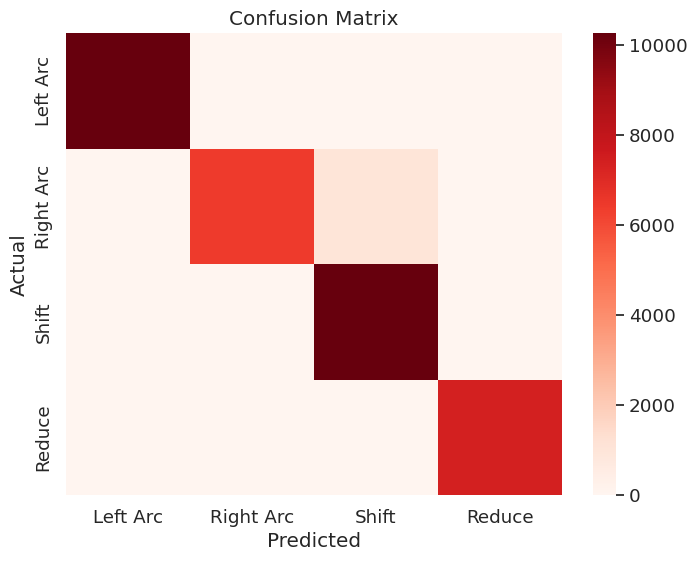

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the confusion matrix stored in test_confusion_matrix
labels = ['Left Arc', 'Right Arc', 'Shift', 'Reduce']

# Create a heatmap using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


When starting from scratch, the Base model experiences a larger average loss than the BERT model. Up until the eighth epoch, it improves, but then it seems to plateau, suggesting that there would be no more notable advancements. The BERT model obtains a smaller loss after only 4 epochs, while the Base model's loss on the training set is still larger after 14 epochs. This shows that, in this situation, the BERT approach is more successful and viable. The same pattern is observed for the Unlabeled Attachment Score, with the base model achieving a score of 71.7%, while the BERT model outperforms it with a score of 82.2%.

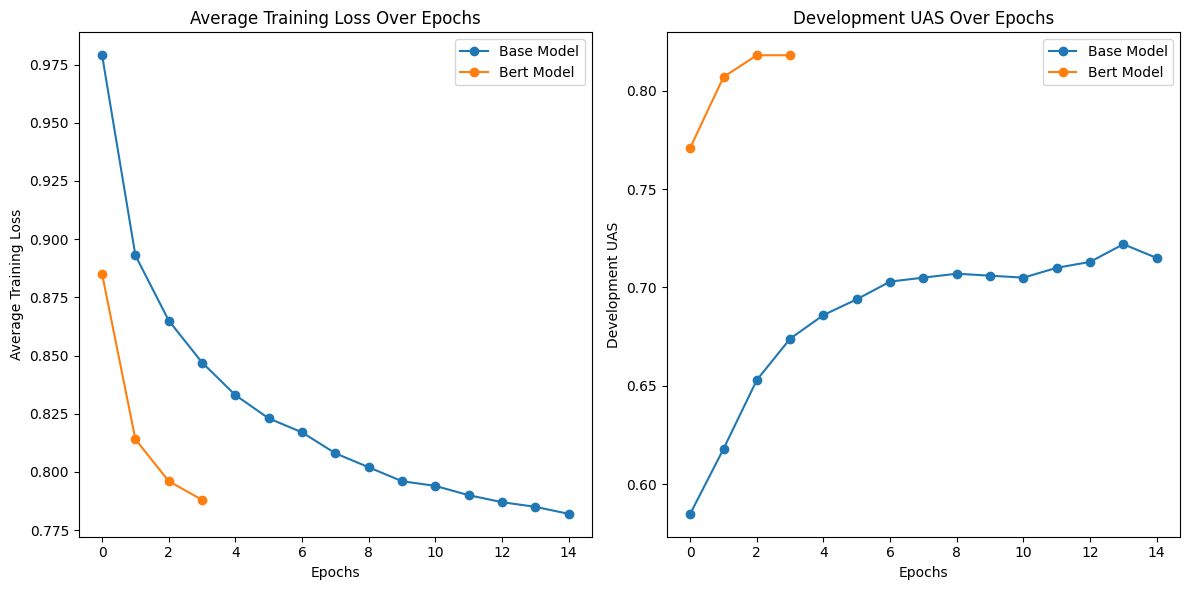

In [2]:
import matplotlib.pyplot as plt

def read_results_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    epochs = []
    avg_train_loss = []
    dev_uas = []
    for line in lines:
        if 'Epoch' in line:
            parts = line.split('|')
            epoch = int(parts[0].split(':')[1].strip())
            train_loss = float(parts[1].split(':')[1].strip())
            uas = float(parts[2].split(':')[1].strip())
            epochs.append(epoch)
            avg_train_loss.append(train_loss)
            dev_uas.append(uas)
    return epochs, avg_train_loss, dev_uas

# Replace with your file paths
base_model_path = '/BaseModelResults.txt'
bert_model_path = '/BertModelResults.txt'

# Read data from files
base_epochs, base_train_loss, base_dev_uas = read_results_file(base_model_path)
bert_epochs, bert_train_loss, bert_dev_uas = read_results_file(bert_model_path)

# Plotting
plt.figure(figsize=(12, 6))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(base_epochs, base_train_loss, label='Base Model', marker='o')
plt.plot(bert_epochs, bert_train_loss, label='Bert Model', marker='o')
plt.title('Average Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.legend()

# Development UAS
plt.subplot(1, 2, 2)
plt.plot(base_epochs, base_dev_uas, label='Base Model', marker='o')
plt.plot(bert_epochs, bert_dev_uas, label='Bert Model', marker='o')
plt.title('Development UAS Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Development UAS')
plt.legend()

plt.tight_layout()
plt.show()

The SoTA results for Universal Dependency, as detailed in this paper https://arxiv.org/pdf/2012.13163.pdf, indicate that the UAS when using BERT is 92.74% (table 1, page 5). Even though the model created for this project shows encouraging outcomes, there is still room for improvement.